In [67]:
import utils
import sys
if 'utils' in sys.modules:
    del sys.modules['utils']
import utils
import torch
from tqdm import tqdm
from torchvision import datasets, transforms
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nbformat
import os
import collections
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

checkpoint_path = 'weights/checkpoint_32x32.pth'
RESUME_TRAINING = False

PRINT_IMG = True
AUGMENT_DATASET = False
AUGMENT_FRACTION = 0.2
TRANSFORM_DATASET = False

COSINE_ANNEALING = True
STEPLR = False
REDUCE_ON_PLATEAU = False

OPTIMIZER='SGD'

### Hyperparameters ###
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 30

WEIGHT_DECAY = 0

### Early Stopping ###
EARLY_STOPPING = True
ES_PATIENCE = 3

SEED = 0

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [26]:
train_dataset, train_dataset_raw = utils.create_train_dataset(TRANSFORM_DATASET, AUGMENT_DATASET, AUGMENT_FRACTION)
test_dataset, validation_dataset, test_dataset_raw = utils.create_test_dataset(validation_split=0.7)

/home/andrea/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dimensione del dataset originale: 60000
Dimensione del dataset trasformato: 60000
Dimensione del sottoinsieme aumentato: 12000


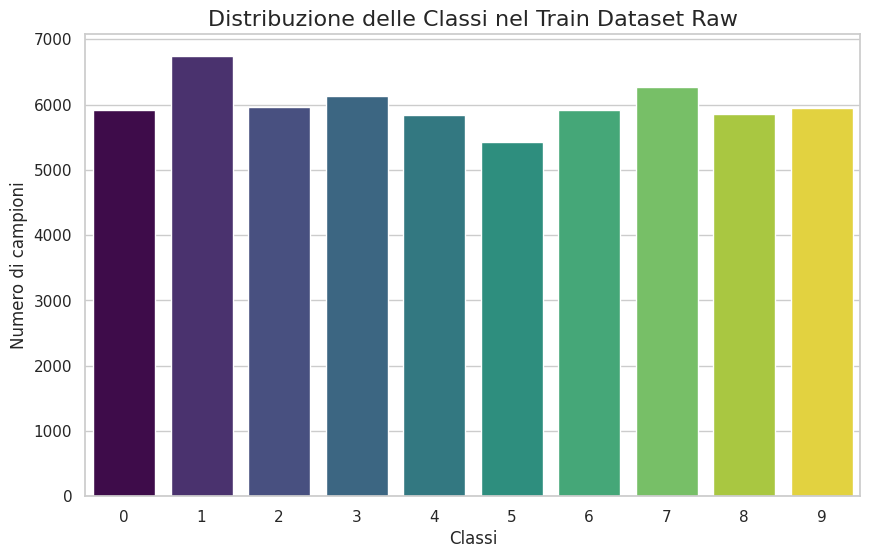

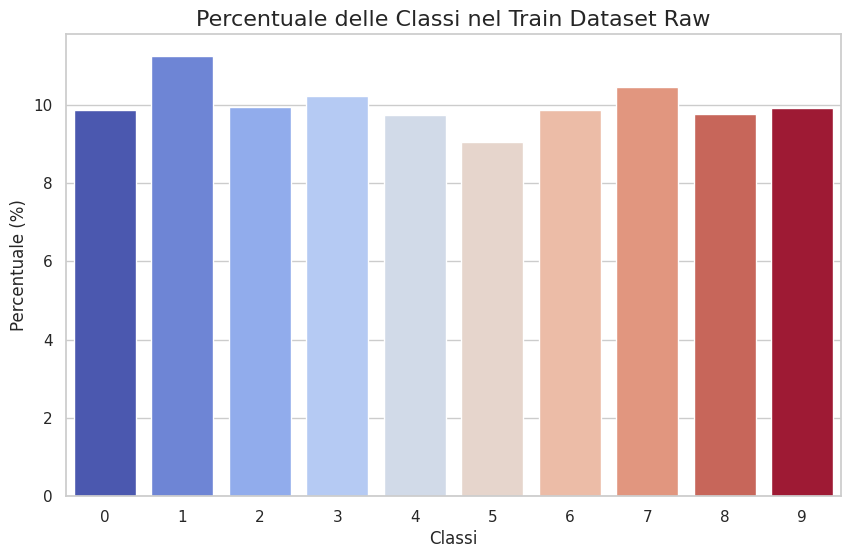

In [27]:
utils.plot_dataset_raw_statistics(train_dataset_raw, "Train Dataset Raw")

Numero totale di campioni: 60000
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 20000, 1: 20000, 2: 20000}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 20000 campioni (33.33%)
Relazione 1: 20000 campioni (33.33%)
Relazione 2: 20000 campioni (33.33%)




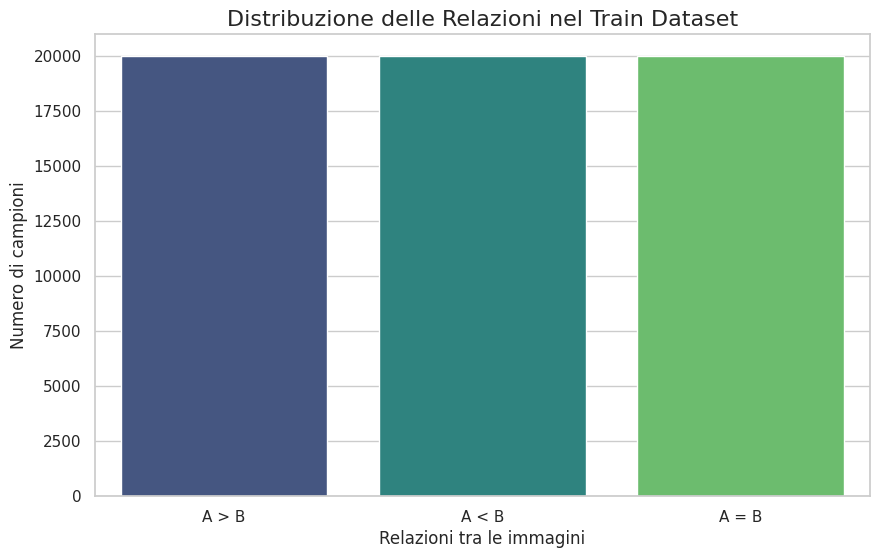

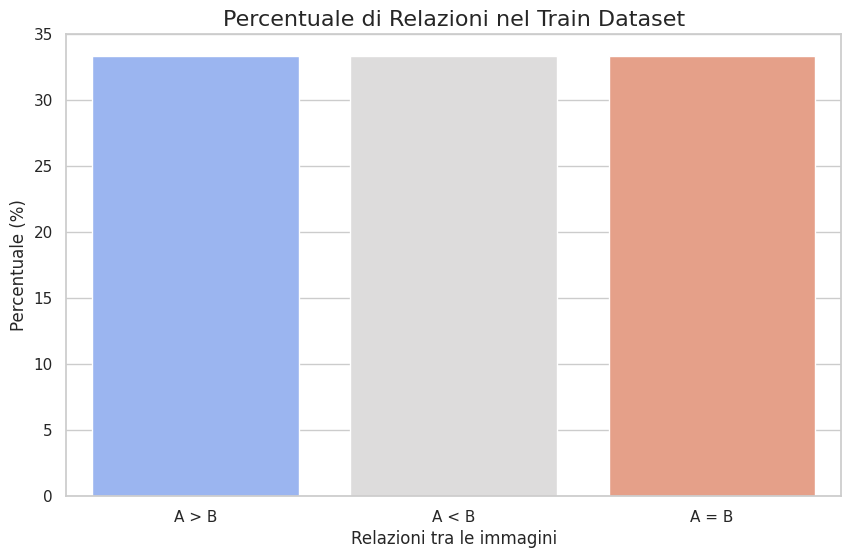

In [28]:
utils.plot_dataset_statistics(train_dataset, dataset_name="Train Dataset")

Numero totale di campioni: 3000
Distribuzione delle relazioni (A > B, A < B, A = B): {2: 979, 0: 986, 1: 1035}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 2: 979 campioni (32.63%)
Relazione 0: 986 campioni (32.87%)
Relazione 1: 1035 campioni (34.50%)




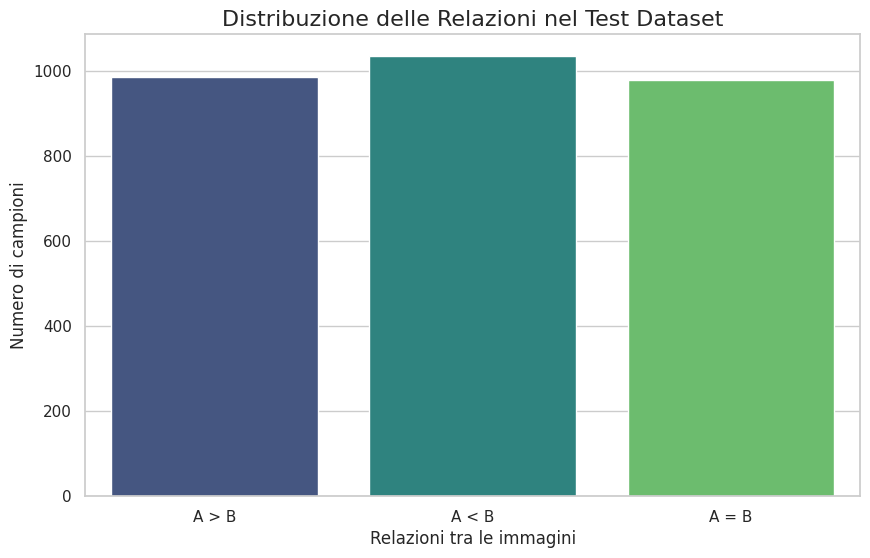

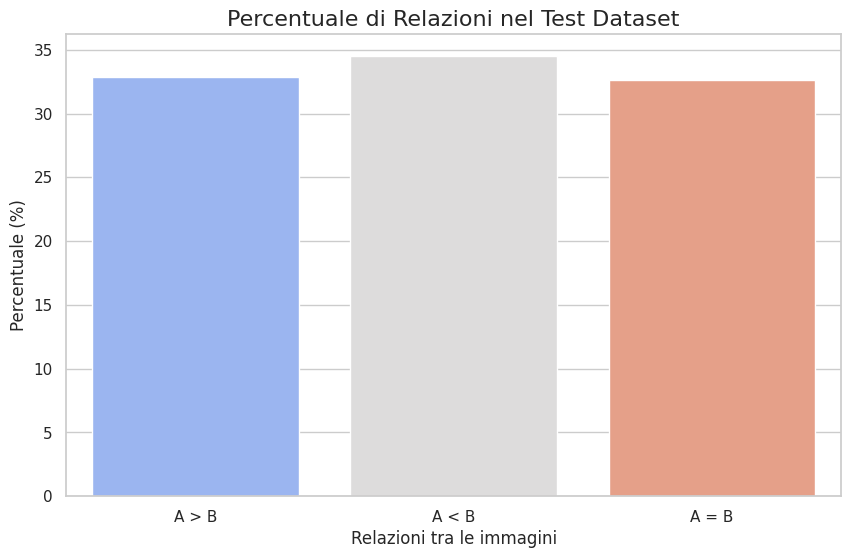

In [29]:
utils.plot_dataset_statistics(test_dataset, dataset_name="Test Dataset")

Numero totale di campioni: 6999
Distribuzione delle relazioni (A > B, A < B, A = B): {0: 2347, 1: 2298, 2: 2354}
Dimensioni delle immagini trovate nel dataset: {torch.Size([2, 32, 32])}
Relazione 0: 2347 campioni (33.53%)
Relazione 1: 2298 campioni (32.83%)
Relazione 2: 2354 campioni (33.63%)




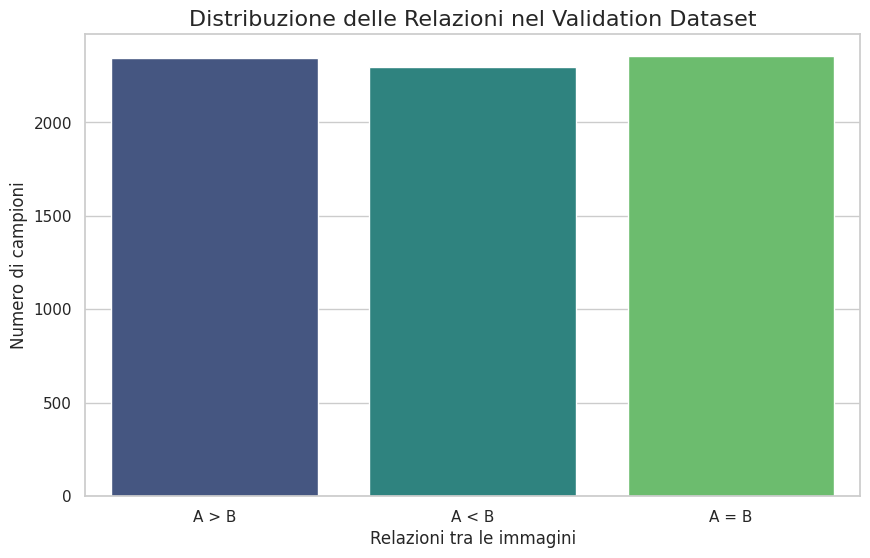

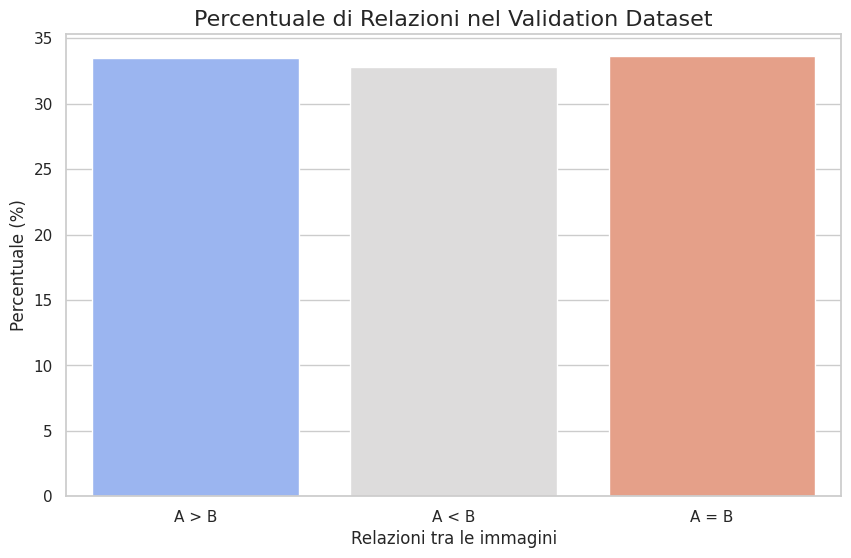

In [30]:
utils.plot_dataset_statistics(validation_dataset, dataset_name="Validation Dataset")

In [31]:
train_loader, validation_loader, test_loader = utils.create_data_loader(train_dataset, validation_dataset, test_dataset, BATCH_SIZE)

In [32]:
print("Size train_loader: ", len(train_loader), " Size train_dataset: ", len(train_dataset))
print("Size validation_loader: ", len(validation_loader), " Size validation_dataset: ", len(validation_dataset))
print("Size test_loader: ", len(test_loader), " Size test_dataset: ", len(test_dataset))

Size train_loader:  469  Size train_dataset:  60000
Size validation_loader:  55  Size validation_dataset:  6999
Size test_loader:  24  Size test_dataset:  3000


In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [69]:
class CustomLeNet5(nn.Module):
    def __init__(self):
        super(CustomLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(2, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CustomLeNet5()
print(model)


CustomLeNet5(
  (conv1): Conv2d(2, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [70]:
# Definisci la funzione di perdita e l'ottimizzatore
criterion = nn.CrossEntropyLoss()
if OPTIMIZER == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
elif OPTIMIZER == 'ADAM':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

if REDUCE_ON_PLATEAU:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
elif COSINE_ANNEALING:
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
elif STEPLR:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7, verbose=True)

images dtype: torch.float32, labels dtype: torch.int64


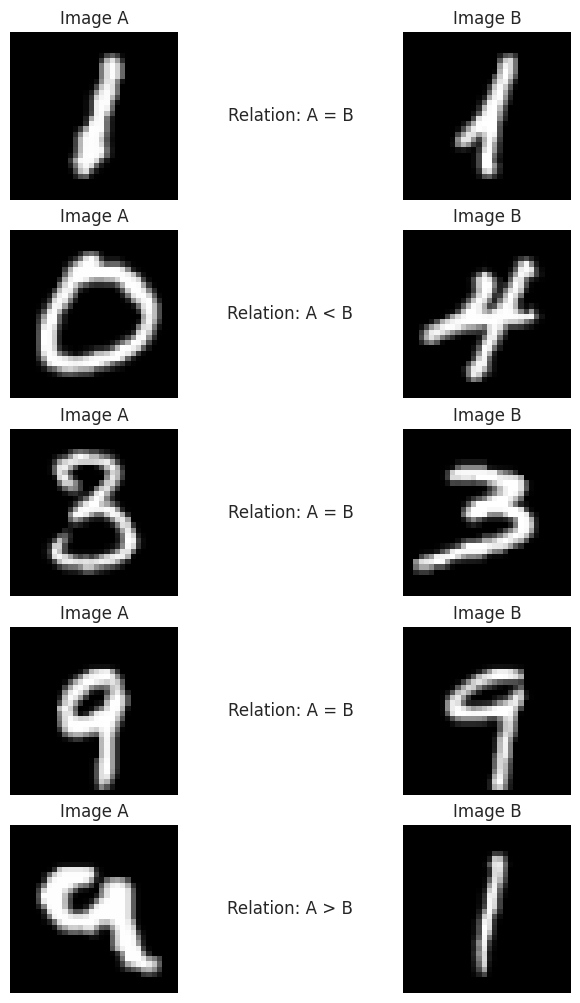

In [71]:

if OPTIMIZER == 'SGD':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_m={MOMENTUM}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"
elif OPTIMIZER == 'ADAM':
    fileName = f"runs/log32x32_bs={BATCH_SIZE}_lr={LEARNING_RATE}_e={EPOCHS}_aug={AUGMENT_DATASET}_tra={TRANSFORM_DATASET}_opt={OPTIMIZER}"

writer = SummaryWriter(fileName)

# Ottieni un batch dal dataloader
batch = next(iter(train_loader))
images, labels = batch

# Stampa il tipo di dato di ciascun tensore per debug
print(f"images dtype: {images.dtype}, labels dtype: {labels.dtype}")

writer.add_graph(model, next(iter(train_loader))[0])

writer.add_figure('Image_pair', utils.show_dataset(train_loader, 5))

In [72]:
# Definisci le liste per salvare i valori di loss e accuracy

def train(train_data_loader, model):
    print('Training')
    train_itr = 0
    correct_train = 0
    total_train = 0
    running_loss = 0.0
    train_loss_list = []
    train_accuracy_list = []
    
    # Inizializzazione della progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        train_loss_list.append(loss_value)
        train_accuracy_list.append(100 * correct_train / total_train)

        train_itr += 1
    
        # Aggiorna il valore della loss nella progress bar per ogni iterazione
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return running_loss / len(train_data_loader), 100 * correct_train / total_train, train_loss_list, train_accuracy_list

def validate(data_loader, model):
    print('Validating')
    val_itr = 0
    correct = 0
    total = 0
    running_loss = 0.0
    val_loss_list = []
    val_accuracy_list = []
    
    prog_bar = tqdm(data_loader, total=len(data_loader))
    
    for i, data in enumerate(prog_bar):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss_value = loss.item()
        running_loss += loss_value
        val_loss_list.append(loss_value)
        val_accuracy_list.append(100 * correct / total)
        val_itr += 1

        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value, 100 * correct / total, val_loss_list, val_accuracy_list

In [73]:
# TRAIN!!!
start_epoch = 0
if RESUME_TRAINING and os.path.exists(checkpoint_path):
    start_epoch, best_val_loss, patience_counter = utils.load_checkpoint(model, optimizer, scheduler, checkpoint_path)

model.train()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
total_val_loss = []
total_val_acc = []
total_train_loss = []
total_train_acc = []
lr_history = []
best_val_loss = float('inf')
for epoch in range(EPOCHS):
        print(f"\nEPOCH {epoch+1} of {EPOCHS}")

        start = time.time()
        train_loss, train_acc, train_loss_list, train_acc_list = train(train_loader, model)
        val_loss, val_acc, val_loss_list, val_acc_list = validate(validation_loader, model)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        total_train_loss.extend(train_loss_list)
        total_train_acc.extend(train_acc_list)
        total_val_loss.extend(val_loss_list)
        total_val_acc.extend(val_acc_list)

        if REDUCE_ON_PLATEAU:
                scheduler.step(val_loss)
        else:
                scheduler.step()

        lr_history.append(optimizer.param_groups[0]['lr'])

        print(f"Epoch #{epoch+1} train loss: {train_loss:.3f} train accuracy: {train_acc:.2f}")   
        print(f"Epoch #{epoch+1} validation loss: {val_loss:.3f} validation accuracy: {val_acc:.2f}")   
        end = time.time()
        print("Learning rate actual: ", optimizer.param_groups[0]['lr'])
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")
        writer.add_scalars('Loss', {
                'Train': train_loss,
                'Validation': val_loss
        }, epoch + 1)
        
        writer.add_scalars('Accuracy', {
                'Train': train_acc,
                'Validation': val_acc
        }, epoch + 1)

        if EARLY_STOPPING:
                if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        best_model_state = model.state_dict()
                else:
                        patience_counter += 1
                        print(f"No improvement for {patience_counter} epoch(s).")
                if patience_counter >= ES_PATIENCE:
                        print(f"Early stopping triggered after {epoch+1} epochs.")
                        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)
                        break

        utils.save_checkpoint(epoch, model, optimizer, scheduler, best_val_loss, patience_counter, checkpoint_path)

if EARLY_STOPPING and 'best_model_state' in locals():
    model.load_state_dict(best_model_state)

# Valida il modello appena trainato con il test set
model.eval()
test_loss, test_acc, _, _ = validate(test_loader, model)
print(f"Test loss: {test_loss:.3f} Test accuracy: {test_acc:.2f}")
writer.add_scalar('Test Loss', test_loss)
writer.add_scalar('Test Accuracy', test_acc)



EPOCH 1 of 30
Training


Loss: 0.5538: 100%|██████████| 469/469 [00:12<00:00, 36.79it/s]


Validating


Loss: 0.7153: 100%|██████████| 55/55 [00:00<00:00, 68.57it/s]


Epoch #1 train loss: 0.827 train accuracy: 61.70
Epoch #1 validation loss: 0.715 validation accuracy: 74.27
Learning rate actual:  0.009972609476841367
Took 0.226 minutes for epoch 1
Checkpoint saved at epoch 1.

EPOCH 2 of 30
Training


Loss: 0.4444: 100%|██████████| 469/469 [00:12<00:00, 37.61it/s]


Validating


Loss: 0.4310: 100%|██████████| 55/55 [00:00<00:00, 76.84it/s]


Epoch #2 train loss: 0.483 train accuracy: 80.60
Epoch #2 validation loss: 0.431 validation accuracy: 85.56
Learning rate actual:  0.009890738003669028
Took 0.220 minutes for epoch 2
Checkpoint saved at epoch 2.

EPOCH 3 of 30
Training


Loss: 0.2050: 100%|██████████| 469/469 [00:12<00:00, 38.12it/s]


Validating


Loss: 0.3473: 100%|██████████| 55/55 [00:00<00:00, 78.47it/s]


Epoch #3 train loss: 0.324 train accuracy: 87.66
Epoch #3 validation loss: 0.347 validation accuracy: 89.34
Learning rate actual:  0.009755282581475769
Took 0.217 minutes for epoch 3
Checkpoint saved at epoch 3.

EPOCH 4 of 30
Training


Loss: 0.3024: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]


Validating


Loss: 0.2495: 100%|██████████| 55/55 [00:00<00:00, 85.41it/s]


Epoch #4 train loss: 0.241 train accuracy: 90.91
Epoch #4 validation loss: 0.250 validation accuracy: 91.46
Learning rate actual:  0.009567727288213004
Took 0.216 minutes for epoch 4
Checkpoint saved at epoch 4.

EPOCH 5 of 30
Training


Loss: 0.1950: 100%|██████████| 469/469 [00:12<00:00, 38.01it/s]


Validating


Loss: 0.2213: 100%|██████████| 55/55 [00:00<00:00, 71.62it/s]


Epoch #5 train loss: 0.196 train accuracy: 92.77
Epoch #5 validation loss: 0.221 validation accuracy: 93.21
Learning rate actual:  0.009330127018922194
Took 0.219 minutes for epoch 5
Checkpoint saved at epoch 5.

EPOCH 6 of 30
Training


Loss: 0.2118: 100%|██████████| 469/469 [00:12<00:00, 38.25it/s]


Validating


Loss: 0.2236: 100%|██████████| 55/55 [00:00<00:00, 76.43it/s]


Epoch #6 train loss: 0.157 train accuracy: 94.39
Epoch #6 validation loss: 0.224 validation accuracy: 92.87
Learning rate actual:  0.009045084971874737
Took 0.216 minutes for epoch 6
No improvement for 1 epoch(s).
Checkpoint saved at epoch 6.

EPOCH 7 of 30
Training


Loss: 0.0755: 100%|██████████| 469/469 [00:11<00:00, 39.34it/s]


Validating


Loss: 0.1200: 100%|██████████| 55/55 [00:00<00:00, 76.80it/s]


Epoch #7 train loss: 0.131 train accuracy: 95.27
Epoch #7 validation loss: 0.120 validation accuracy: 93.80
Learning rate actual:  0.00871572412738697
Took 0.211 minutes for epoch 7
Checkpoint saved at epoch 7.

EPOCH 8 of 30
Training


Loss: 0.1506: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]


Validating


Loss: 0.1100: 100%|██████████| 55/55 [00:00<00:00, 67.88it/s]


Epoch #8 train loss: 0.110 train accuracy: 96.05
Epoch #8 validation loss: 0.110 validation accuracy: 93.73
Learning rate actual:  0.008345653031794291
Took 0.217 minutes for epoch 8
Checkpoint saved at epoch 8.

EPOCH 9 of 30
Training


Loss: 0.0966: 100%|██████████| 469/469 [00:12<00:00, 37.21it/s]


Validating


Loss: 0.0786: 100%|██████████| 55/55 [00:00<00:00, 76.73it/s]


Epoch #9 train loss: 0.093 train accuracy: 96.64
Epoch #9 validation loss: 0.079 validation accuracy: 94.04
Learning rate actual:  0.007938926261462365
Took 0.222 minutes for epoch 9
Checkpoint saved at epoch 9.

EPOCH 10 of 30
Training


Loss: 0.0751: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]


Validating


Loss: 0.0477: 100%|██████████| 55/55 [00:00<00:00, 67.15it/s]


Epoch #10 train loss: 0.077 train accuracy: 97.24
Epoch #10 validation loss: 0.048 validation accuracy: 94.60
Learning rate actual:  0.007499999999999999
Took 0.229 minutes for epoch 10
Checkpoint saved at epoch 10.

EPOCH 11 of 30
Training


Loss: 0.0515: 100%|██████████| 469/469 [00:12<00:00, 37.26it/s]


Validating


Loss: 0.0709: 100%|██████████| 55/55 [00:00<00:00, 74.42it/s]


Epoch #11 train loss: 0.066 train accuracy: 97.71
Epoch #11 validation loss: 0.071 validation accuracy: 94.56
Learning rate actual:  0.007033683215379001
Took 0.222 minutes for epoch 11
No improvement for 1 epoch(s).
Checkpoint saved at epoch 11.

EPOCH 12 of 30
Training


Loss: 0.0164: 100%|██████████| 469/469 [00:12<00:00, 37.36it/s]


Validating


Loss: 0.0426: 100%|██████████| 55/55 [00:00<00:00, 77.73it/s]


Epoch #12 train loss: 0.053 train accuracy: 98.14
Epoch #12 validation loss: 0.043 validation accuracy: 94.78
Learning rate actual:  0.0065450849718747366
Took 0.221 minutes for epoch 12
Checkpoint saved at epoch 12.

EPOCH 13 of 30
Training


Loss: 0.0346: 100%|██████████| 469/469 [00:12<00:00, 38.35it/s]


Validating


Loss: 0.0379: 100%|██████████| 55/55 [00:00<00:00, 68.34it/s]


Epoch #13 train loss: 0.040 train accuracy: 98.60
Epoch #13 validation loss: 0.038 validation accuracy: 94.91
Learning rate actual:  0.006039558454088796
Took 0.217 minutes for epoch 13
Checkpoint saved at epoch 13.

EPOCH 14 of 30
Training


Loss: 0.0067: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]


Validating


Loss: 0.0258: 100%|██████████| 55/55 [00:00<00:00, 65.52it/s]


Epoch #14 train loss: 0.030 train accuracy: 98.97
Epoch #14 validation loss: 0.026 validation accuracy: 94.87
Learning rate actual:  0.0055226423163382676
Took 0.226 minutes for epoch 14
Checkpoint saved at epoch 14.

EPOCH 15 of 30
Training


Loss: 0.0097: 100%|██████████| 469/469 [00:12<00:00, 36.63it/s]


Validating


Loss: 0.0368: 100%|██████████| 55/55 [00:00<00:00, 71.42it/s]


Epoch #15 train loss: 0.022 train accuracy: 99.28
Epoch #15 validation loss: 0.037 validation accuracy: 94.88
Learning rate actual:  0.005000000000000001
Took 0.226 minutes for epoch 15
No improvement for 1 epoch(s).
Checkpoint saved at epoch 15.

EPOCH 16 of 30
Training


Loss: 0.0208: 100%|██████████| 469/469 [00:12<00:00, 36.74it/s]


Validating


Loss: 0.0305: 100%|██████████| 55/55 [00:00<00:00, 73.48it/s]


Epoch #16 train loss: 0.016 train accuracy: 99.49
Epoch #16 validation loss: 0.031 validation accuracy: 95.07
Learning rate actual:  0.0044773576836617335
Took 0.225 minutes for epoch 16
No improvement for 2 epoch(s).
Checkpoint saved at epoch 16.

EPOCH 17 of 30
Training


Loss: 0.0180: 100%|██████████| 469/469 [00:12<00:00, 38.24it/s]


Validating


Loss: 0.0525: 100%|██████████| 55/55 [00:00<00:00, 71.69it/s]


Epoch #17 train loss: 0.011 train accuracy: 99.72
Epoch #17 validation loss: 0.052 validation accuracy: 95.26
Learning rate actual:  0.003960441545911203
Took 0.217 minutes for epoch 17
No improvement for 3 epoch(s).
Early stopping triggered after 17 epochs.
Checkpoint saved at epoch 17.
Validating


Loss: 0.3413: 100%|██████████| 24/24 [00:00<00:00, 76.24it/s]

Test loss: 0.341 Test accuracy: 94.80


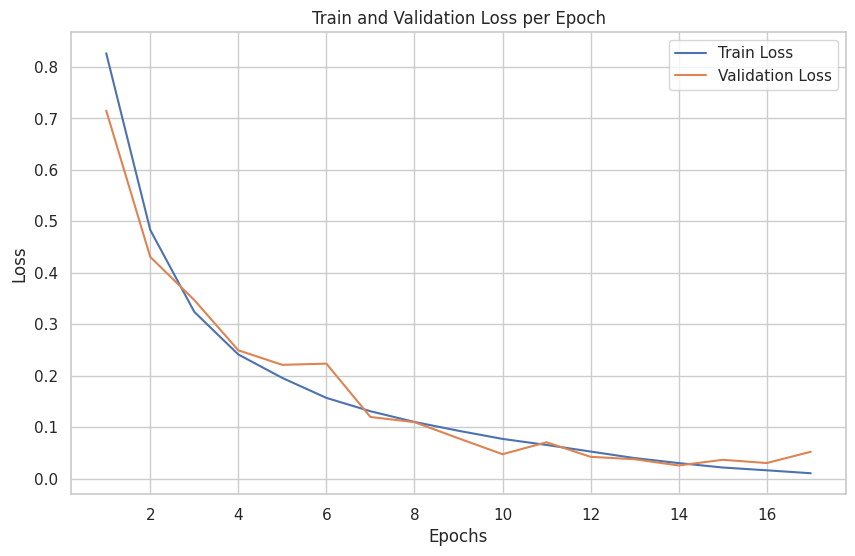

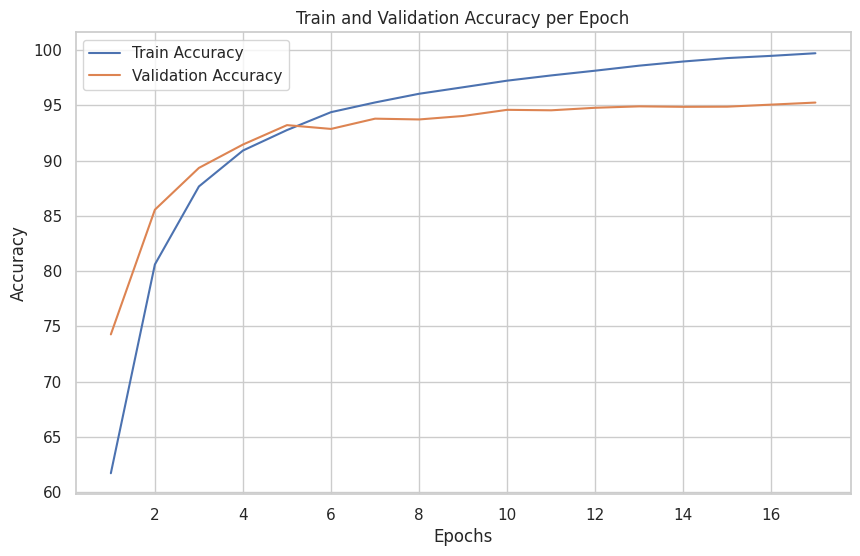

In [74]:
utils.plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies,
                        total_train_loss, total_val_loss, total_train_acc, total_val_acc)

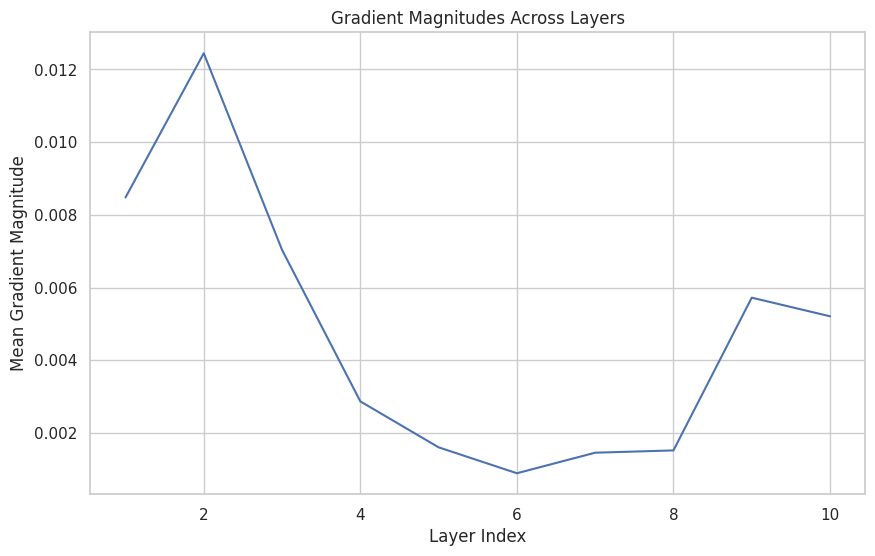

In [75]:
utils.plot_gradient(model)

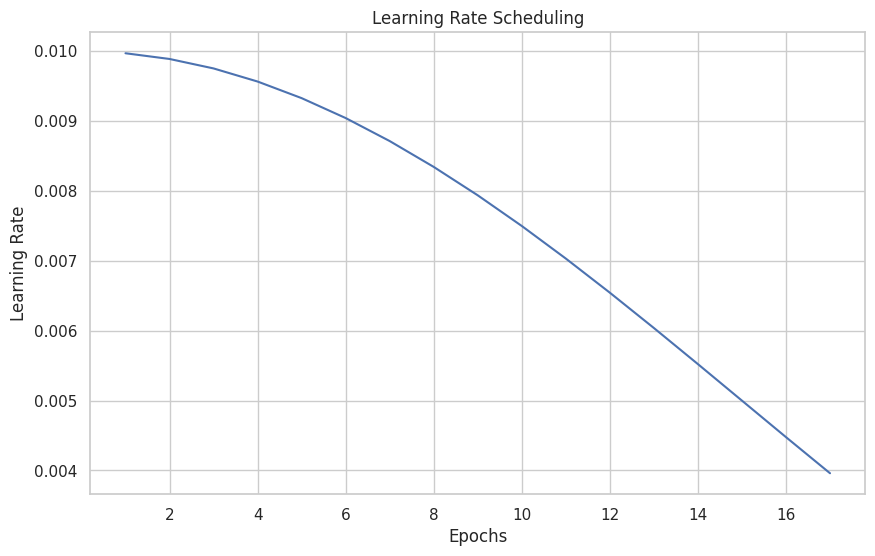

In [76]:
utils.plot_lr_scheduler(lr_history)

In [77]:
all_preds_val, all_labels_val, all_images_A_val, all_images_B_val = utils.inference(model, validation_loader, device)
all_preds_test, all_labels_test, all_images_A_test, all_images_B_test = utils.inference(model, test_loader, device)

332 previsioni errate trovate.


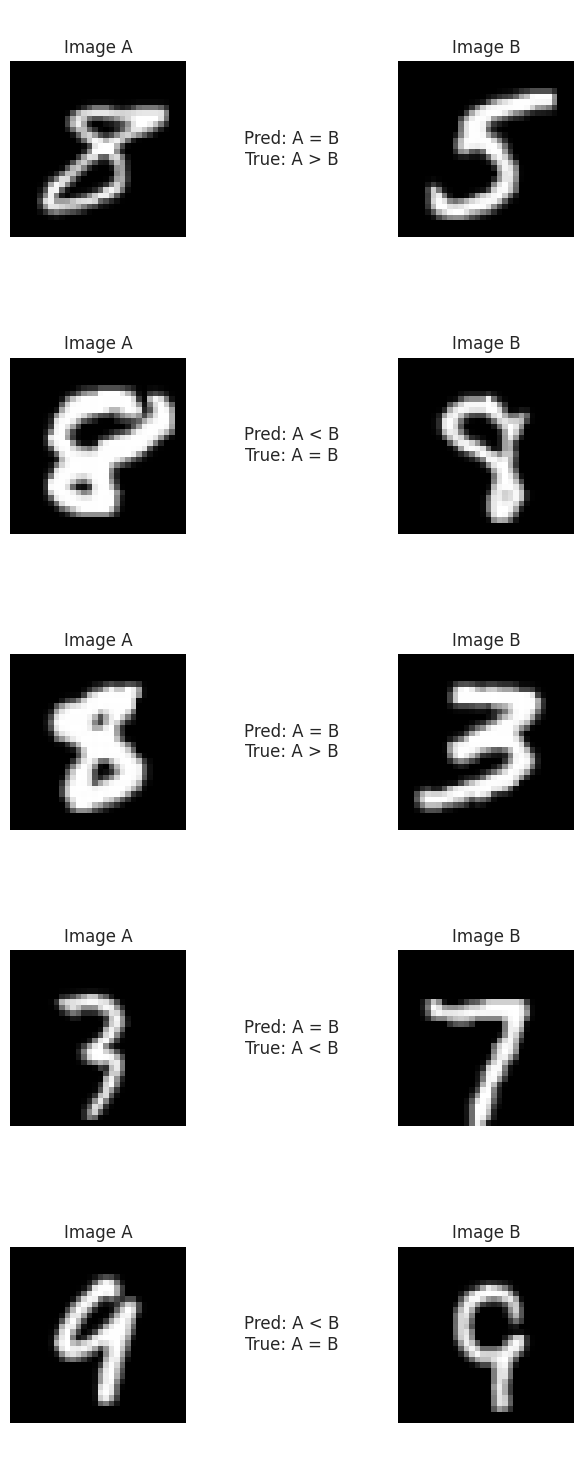

In [78]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_validation', utils.show_incorrect_predictions(all_preds_val, all_labels_val, all_images_A_val, all_images_B_val, num_images=5))

In [ ]:
# Visualizza alcune previsioni errate
writer.add_figure('Incorrect_predictions_test', utils.show_incorrect_predictions(all_preds_test, all_labels_test, all_images_A_test, all_images_B_test, num_images=5))

156 previsioni errate trovate.


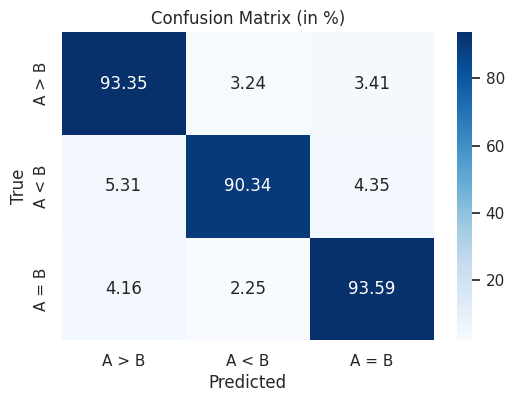

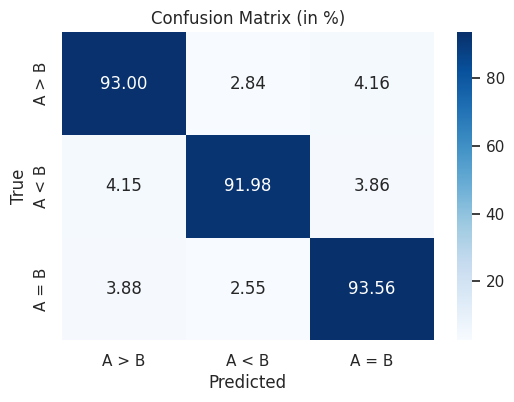

In [ ]:
# Calcola e visualizza la matrice di confusione
writer.add_figure('Confusion_matrix_validation', utils.plot_confusion_matrix(all_preds_val, all_labels_val))
writer.add_figure('Confusion_matrix_test', utils.plot_confusion_matrix(all_preds_test, all_labels_test))
#plot_confusion_matrix(model, test_loader, device)


In [ ]:
# Stampa il report delle metriche
utils.classification_metrics(all_preds_test, all_labels_test)

              precision    recall  f1-score   support

       A > B       0.92      0.93      0.92       986
       A < B       0.95      0.92      0.93      1035
       A = B       0.92      0.94      0.93       979

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



Precision: Il numero di veri positivi diviso per il numero di esempi che sono stati predetti come positivi.
Recall (Sensibilità): Il numero di veri positivi diviso per il numero di esempi che appartengono effettivamente alla classe positiva.
F1-Score: La media armonica tra precisione e recall. È utile quando hai un dataset squilibrato.
Support: Il numero di campioni effettivi per ogni classe.

In [ ]:
def save_notebook_copy(notebook_name='main.ipynb'):
    # Leggi il notebook attuale
    with open(notebook_name, 'r') as f:
        notebook_content = nbformat.read(f, as_version=4)
    
    # Costruisci il nome base del nuovo notebook
    if OPTIMIZER == 'SGD':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_MOM={MOMENTUM}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    elif OPTIMIZER == 'ADAM':
        base_name = f"run32x32_BS={BATCH_SIZE}_LR={LEARNING_RATE}_EPOCHS={EPOCHS}_AUG={AUGMENT_DATASET}_TRA={TRANSFORM_DATASET}_OPT={OPTIMIZER}"
    else:
        base_name = "run32x32"

    # Aggiungi estensione .ipynb
    new_notebook_name = f"{base_name}.ipynb"

    # Evita sovrascritture aggiungendo un numero incrementale se il file esiste
    counter = 1
    while os.path.exists(new_notebook_name):
        new_notebook_name = f"{base_name}_{counter}.ipynb"
        counter += 1

    # Salva il notebook con il nuovo nome
    with open(new_notebook_name, 'w') as f:
        nbformat.write(notebook_content, f)
    
    print(f"Notebook saved as {new_notebook_name}")


# Specifica il nome del notebook attuale
save_notebook_copy('main_32x32.ipynb')


Notebook saved as run32x32_BS=128_LR=0.0005_EPOCHS=30_AUG=False_TRA=False_OPT=ADAM.ipynb


In [ ]:
writer.close()